In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import os


In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = {'train': r'C:\work\Pomegranate Fruit Diseases Dataset for Deep Learning Models\data\data\passionfruit_dataset_crop\train', 'val': r'C:\work\Pomegranate Fruit Diseases Dataset for Deep Learning Models\data\data\passionfruit_dataset_crop\val'}
image_datasets = {x: datasets.ImageFolder(data_dir[x], data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names


{'train': 620, 'val': 314}


['A', 'B', 'C', 'VIP']

In [6]:
def create_model(num_classes):
    base_model = models.resnet18(pretrained=True)
    num_ftrs = base_model.fc.in_features
    base_model.fc = nn.Linear(num_ftrs, num_classes)
    
    # for name, param in base_model.named_parameters():
    #     if "fc" in name:  # Unfreeze the final classification layer
    #         param.requires_grad = True
    #     else:
    #         param.requires_grad = False

    return base_model

model = create_model(num_classes=4)


c:\diagram\ANPR\anprsys\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\diagram\ANPR\anprsys\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Dùng tqdm để hiển thị progress bar cho mỗi epoch
            progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} phase', leave=False)

            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Tính toán loss và accuracy tạm thời
                batch_loss = running_loss / ((progress_bar.n + 1) * inputs.size(0))
                batch_acc = running_corrects.double() / ((progress_bar.n + 1) * inputs.size(0))

                # Cập nhật thông tin trên progress bar
                progress_bar.set_postfix({'loss': batch_loss, 'acc': batch_acc})

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Lưu lại lịch sử loss và accuracy, đảm bảo chuyển từ GPU sang CPU
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.cpu().item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.cpu().item())
        
        # Cập nhật learning rate
        scheduler.step()

    return model, history

# Định nghĩa criterion, optimizer, scheduler và thiết bị
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Huấn luyện mô hình
# model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=5)




In [8]:
import matplotlib.pyplot as plt

# Giả sử bạn đã huấn luyện xong mô hình và có lịch sử được trả về
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=100)
print("Training complete!")




Epoch 1/100


Train Loss: 0.8975 Acc: 0.6097


Val Loss: 0.4831 Acc: 0.8408
Epoch 2/100


Train Loss: 0.2996 Acc: 0.9113


Val Loss: 0.2954 Acc: 0.8949
Epoch 3/100


Train Loss: 0.1611 Acc: 0.9629


Val Loss: 0.2373 Acc: 0.9140
Epoch 4/100


Train Loss: 0.1220 Acc: 0.9661


Val Loss: 0.2068 Acc: 0.9236
Epoch 5/100


Train Loss: 0.0819 Acc: 0.9839


Val Loss: 0.1160 Acc: 0.9936
Epoch 6/100


Train Loss: 0.0833 Acc: 0.9790


Val Loss: 0.1082 Acc: 0.9777
Epoch 7/100


Train Loss: 0.0528 Acc: 0.9935


Val Loss: 0.1375 Acc: 0.9682
Epoch 8/100


Train Loss: 0.0614 Acc: 0.9790


Val Loss: 0.1040 Acc: 0.9713
Epoch 9/100


Train Loss: 0.0489 Acc: 0.9952


Val Loss: 0.0886 Acc: 0.9904
Epoch 10/100


Train Loss: 0.0287 Acc: 0.9968


Val Loss: 0.1421 Acc: 0.9427
Epoch 11/100


Train Loss: 0.0350 Acc: 0.9952


Val Loss: 0.0777 Acc: 0.9873
Epoch 12/100


Train Loss: 0.0357 Acc: 0.9919


Val Loss: 0.0804 Acc: 0.9745
Epoch 13/100


Train Loss: 0.0242 Acc: 0.9952


Val Loss: 0.0786 Acc: 0.9745
Epoch 14/100


Train Loss: 0.0269 Acc: 0.9984


Val Loss: 0.0786 Acc: 0.9713
Epoch 15/100


Train Loss: 0.0384 Acc: 0.9887


Val Loss: 0.0703 Acc: 0.9904
Epoch 16/100


Train Loss: 0.0386 Acc: 0.9903


Val Loss: 0.0722 Acc: 0.9873
Epoch 17/100


Train Loss: 0.0254 Acc: 0.9984


Val Loss: 0.0752 Acc: 0.9841
Epoch 18/100


Train Loss: 0.0203 Acc: 0.9984


Val Loss: 0.0816 Acc: 0.9745
Epoch 19/100


Train Loss: 0.0237 Acc: 0.9952


Val Loss: 0.0782 Acc: 0.9745
Epoch 20/100


Train Loss: 0.0230 Acc: 1.0000


Val Loss: 0.0800 Acc: 0.9745
Epoch 21/100


Train Loss: 0.0292 Acc: 0.9984


Val Loss: 0.0853 Acc: 0.9777
Epoch 22/100


Train Loss: 0.0271 Acc: 0.9952


Val Loss: 0.0773 Acc: 0.9777
Epoch 23/100


Train Loss: 0.0280 Acc: 0.9952


Val Loss: 0.0909 Acc: 0.9713
Epoch 24/100


Train Loss: 0.0209 Acc: 0.9984


Val Loss: 0.0879 Acc: 0.9745
Epoch 25/100


Train Loss: 0.0248 Acc: 0.9952


Val Loss: 0.0854 Acc: 0.9713
Epoch 26/100


Train Loss: 0.0305 Acc: 0.9919


Val Loss: 0.0912 Acc: 0.9650
Epoch 27/100


Train Loss: 0.0235 Acc: 0.9984


Val Loss: 0.0864 Acc: 0.9777
Epoch 28/100


Train Loss: 0.0198 Acc: 1.0000


Val Loss: 0.0905 Acc: 0.9682
Epoch 29/100


Train Loss: 0.0221 Acc: 0.9968


Val Loss: 0.0886 Acc: 0.9713
Epoch 30/100


Train Loss: 0.0231 Acc: 0.9984


Val Loss: 0.0843 Acc: 0.9745
Epoch 31/100


Train Loss: 0.0168 Acc: 1.0000


Val Loss: 0.0889 Acc: 0.9713
Epoch 32/100


Train Loss: 0.0217 Acc: 0.9984


Val Loss: 0.0705 Acc: 0.9809
Epoch 33/100


Train Loss: 0.0336 Acc: 0.9935


Val Loss: 0.0787 Acc: 0.9745
Epoch 34/100


Train Loss: 0.0179 Acc: 0.9984


Val Loss: 0.0947 Acc: 0.9713
Epoch 35/100


Train Loss: 0.0290 Acc: 0.9952


Val Loss: 0.0767 Acc: 0.9745
Epoch 36/100


Train Loss: 0.0286 Acc: 0.9968


Val Loss: 0.0736 Acc: 0.9745
Epoch 37/100


Train Loss: 0.0203 Acc: 1.0000


Val Loss: 0.0807 Acc: 0.9713
Epoch 38/100


Train Loss: 0.0221 Acc: 0.9952


Val Loss: 0.0779 Acc: 0.9745
Epoch 39/100


Train Loss: 0.0256 Acc: 0.9919


Val Loss: 0.0815 Acc: 0.9777
Epoch 40/100


Train Loss: 0.0218 Acc: 1.0000


Val Loss: 0.0734 Acc: 0.9745
Epoch 41/100


Train Loss: 0.0178 Acc: 1.0000


Val Loss: 0.0777 Acc: 0.9841
Epoch 42/100


Train Loss: 0.0196 Acc: 1.0000


Val Loss: 0.0966 Acc: 0.9745
Epoch 43/100


Train Loss: 0.0264 Acc: 0.9968


Val Loss: 0.0767 Acc: 0.9745
Epoch 44/100


Train Loss: 0.0237 Acc: 1.0000


Val Loss: 0.0757 Acc: 0.9745
Epoch 45/100


Train Loss: 0.0213 Acc: 1.0000


Val Loss: 0.0858 Acc: 0.9713
Epoch 46/100


Train Loss: 0.0231 Acc: 0.9984


Val Loss: 0.0839 Acc: 0.9745
Epoch 47/100


Train Loss: 0.0242 Acc: 0.9968


Val Loss: 0.0710 Acc: 0.9841
Epoch 48/100


Train Loss: 0.0219 Acc: 0.9984


Val Loss: 0.0806 Acc: 0.9777
Epoch 49/100


Train Loss: 0.0206 Acc: 0.9984


Val Loss: 0.0853 Acc: 0.9745
Epoch 50/100


Train Loss: 0.0153 Acc: 1.0000


Val Loss: 0.0751 Acc: 0.9745
Epoch 51/100


Train Loss: 0.0214 Acc: 1.0000


Val Loss: 0.0793 Acc: 0.9745
Epoch 52/100


Train Loss: 0.0272 Acc: 0.9968


Val Loss: 0.0741 Acc: 0.9904
Epoch 53/100


Train Loss: 0.0229 Acc: 0.9968


Val Loss: 0.0823 Acc: 0.9745
Epoch 54/100


Train Loss: 0.0278 Acc: 0.9935


Val Loss: 0.0775 Acc: 0.9745
Epoch 55/100


Train Loss: 0.0231 Acc: 0.9984


Val Loss: 0.0791 Acc: 0.9745
Epoch 56/100


Train Loss: 0.0186 Acc: 1.0000


Val Loss: 0.0873 Acc: 0.9713
Epoch 57/100


Train Loss: 0.0232 Acc: 1.0000


Val Loss: 0.0644 Acc: 0.9904
Epoch 58/100


Train Loss: 0.0230 Acc: 0.9984


Val Loss: 0.0839 Acc: 0.9713
Epoch 59/100


Train Loss: 0.0274 Acc: 0.9968


Val Loss: 0.0930 Acc: 0.9713
Epoch 60/100


Train Loss: 0.0328 Acc: 0.9903


Val Loss: 0.0690 Acc: 0.9841
Epoch 61/100


Train Loss: 0.0256 Acc: 0.9952


Val Loss: 0.0913 Acc: 0.9713
Epoch 62/100


Train Loss: 0.0266 Acc: 0.9968


Val Loss: 0.0780 Acc: 0.9745
Epoch 63/100


Train Loss: 0.0221 Acc: 0.9968


Val Loss: 0.0760 Acc: 0.9809
Epoch 64/100


Train Loss: 0.0198 Acc: 0.9984


Val Loss: 0.0752 Acc: 0.9745
Epoch 65/100


Train Loss: 0.0178 Acc: 1.0000


Val Loss: 0.0805 Acc: 0.9745
Epoch 66/100


Train Loss: 0.0205 Acc: 1.0000


Val Loss: 0.0953 Acc: 0.9713
Epoch 67/100


Train Loss: 0.0233 Acc: 0.9984


Val Loss: 0.0878 Acc: 0.9713
Epoch 68/100


Train Loss: 0.0286 Acc: 0.9968


Val Loss: 0.0805 Acc: 0.9745
Epoch 69/100


Train Loss: 0.0230 Acc: 0.9984


Val Loss: 0.0883 Acc: 0.9713
Epoch 70/100


Train Loss: 0.0274 Acc: 0.9968


Val Loss: 0.0819 Acc: 0.9713
Epoch 71/100


Train Loss: 0.0166 Acc: 1.0000


Val Loss: 0.0783 Acc: 0.9745
Epoch 72/100


Train Loss: 0.0243 Acc: 0.9952


Val Loss: 0.0759 Acc: 0.9841
Epoch 73/100


Train Loss: 0.0258 Acc: 1.0000


Val Loss: 0.0851 Acc: 0.9713
Epoch 74/100


Train Loss: 0.0260 Acc: 0.9952


Val Loss: 0.0839 Acc: 0.9745
Epoch 75/100


Train Loss: 0.0212 Acc: 0.9984


Val Loss: 0.0861 Acc: 0.9745
Epoch 76/100


Train Loss: 0.0229 Acc: 1.0000


Val Loss: 0.0802 Acc: 0.9841
Epoch 77/100


Train Loss: 0.0183 Acc: 1.0000


Val Loss: 0.0815 Acc: 0.9745
Epoch 78/100


Train Loss: 0.0224 Acc: 1.0000


Val Loss: 0.0714 Acc: 0.9904
Epoch 79/100


Train Loss: 0.0177 Acc: 1.0000


Val Loss: 0.0755 Acc: 0.9841
Epoch 80/100


Train Loss: 0.0313 Acc: 0.9952


Val Loss: 0.0761 Acc: 0.9745
Epoch 81/100


Train Loss: 0.0256 Acc: 0.9984


Val Loss: 0.0879 Acc: 0.9713
Epoch 82/100


Train Loss: 0.0173 Acc: 1.0000


Val Loss: 0.0820 Acc: 0.9745
Epoch 83/100


Train Loss: 0.0187 Acc: 1.0000


Val Loss: 0.0930 Acc: 0.9745
Epoch 84/100


Train Loss: 0.0273 Acc: 0.9984


Val Loss: 0.0749 Acc: 0.9745
Epoch 85/100


Train Loss: 0.0248 Acc: 0.9968


Val Loss: 0.0907 Acc: 0.9745
Epoch 86/100


Train Loss: 0.0236 Acc: 0.9968


Val Loss: 0.0832 Acc: 0.9745
Epoch 87/100


Train Loss: 0.0230 Acc: 0.9984


Val Loss: 0.0967 Acc: 0.9682
Epoch 88/100


Train Loss: 0.0196 Acc: 1.0000


Val Loss: 0.0744 Acc: 0.9745
Epoch 89/100


Train Loss: 0.0284 Acc: 0.9984


Val Loss: 0.0728 Acc: 0.9745
Epoch 90/100


Train Loss: 0.0319 Acc: 0.9935


Val Loss: 0.0756 Acc: 0.9777
Epoch 91/100


Train Loss: 0.0261 Acc: 0.9984


Val Loss: 0.0900 Acc: 0.9713
Epoch 92/100


Train Loss: 0.0268 Acc: 0.9952


Val Loss: 0.0881 Acc: 0.9713
Epoch 93/100


Train Loss: 0.0244 Acc: 1.0000


Val Loss: 0.0838 Acc: 0.9713
Epoch 94/100


Train Loss: 0.0226 Acc: 0.9968


Val Loss: 0.0788 Acc: 0.9745
Epoch 95/100


Train Loss: 0.0194 Acc: 1.0000


Val Loss: 0.0830 Acc: 0.9745
Epoch 96/100


Train Loss: 0.0201 Acc: 0.9968


Val Loss: 0.0806 Acc: 0.9713
Epoch 97/100


Train Loss: 0.0198 Acc: 0.9984


Val Loss: 0.0770 Acc: 0.9745
Epoch 98/100


Train Loss: 0.0286 Acc: 0.9919


Val Loss: 0.0836 Acc: 0.9745
Epoch 99/100


Train Loss: 0.0223 Acc: 0.9984


Val Loss: 0.0751 Acc: 0.9745
Epoch 100/100


Train Loss: 0.0178 Acc: 1.0000


Val Loss: 0.0869 Acc: 0.9745
Training complete!


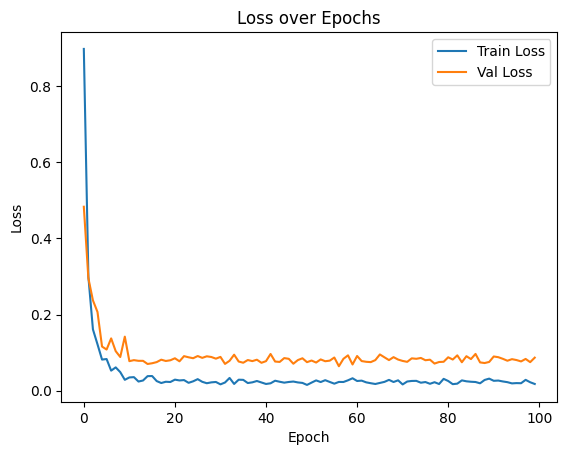

Training complete and data saved!


In [9]:

# Vẽ và lưu biểu đồ loss và accuracy

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss_plot_full_2.png')



plt.show()

# Lưu lịch sử huấn luyện vào file
with open('training_historyfull_2.pkl', 'wb') as f:
    pickle.dump(history, f)

print("Training complete and data saved!")

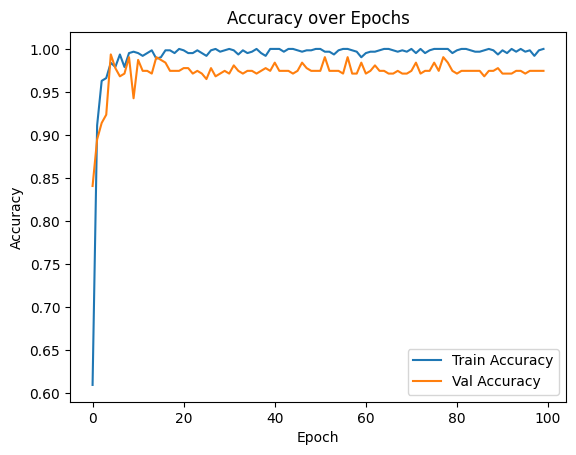

In [10]:

plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.savefig('accuracy_plot_full_2.png')
plt.show()

In [11]:
torch.save(model.state_dict(), 'model_weights.pth')

In [22]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
import os
# Thiết lập thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tải mô hình
model_path = 'model_weights.pth'
model = resnet18(pretrained=False, num_classes=4)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Chuẩn bị dữ liệu
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#image_path = r'C:\work\data\data\passionfruit_dataset_crop\train\B\2023-07-14-17-04-51_0.jpg'
folder_path = r'C:\work\Pomegranate Fruit Diseases Dataset for Deep Learning Models\data\data\passionfruit_dataset\train\VIP'

# Duyệt qua các file trong thư mục
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):  # Kiểm tra định dạng file, có thể thay đổi tùy ý
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0)  # Thêm một chiều batch
        image = image.to(device)

        # Dự đoán
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs.data, 1)
            print(f'Image: {filename} - Predicted class: {predicted.item()}')

Image: 2023-07-14-16-31-10_0.jpg - Predicted class: 0
Image: 2023-07-14-16-31-25_0.jpg - Predicted class: 0
Image: 2023-07-14-16-31-31_0.jpg - Predicted class: 0
Image: 2023-07-14-16-31-46_0.jpg - Predicted class: 0
Image: 2023-07-14-16-32-01_0.jpg - Predicted class: 0
Image: 2023-07-14-16-32-10_0.jpg - Predicted class: 0
Image: 2023-07-14-16-32-15_0.jpg - Predicted class: 0
Image: 2023-07-14-16-32-21_0.jpg - Predicted class: 0
Image: 2023-07-14-16-32-31_0.jpg - Predicted class: 0
Image: 2023-07-14-16-32-37_0.jpg - Predicted class: 0
Image: 2023-07-14-16-32-42_0.jpg - Predicted class: 0
Image: 2023-07-14-16-32-50_0.jpg - Predicted class: 0
Image: 2023-07-14-16-32-58_0.jpg - Predicted class: 0
Image: 2023-07-14-16-33-03_0.jpg - Predicted class: 0
Image: 2023-07-14-16-33-10_0.jpg - Predicted class: 0
Image: 2023-07-14-16-33-16_0.jpg - Predicted class: 0
Image: 2023-07-14-16-33-55_0.jpg - Predicted class: 3
Image: 2023-07-14-16-34-59_0.jpg - Predicted class: 0
Image: 2023-07-14-16-35-12_0